# CHAPTER 3 - Deep Neural Networks for Time Series Forecasting the Easy Way

_pg. 31-50_
  
   
   
# PART 1 - Prepare the Data
_pg. 32-36_

## Getting the data from the internet  
This example uses data from the internet, which we need to download and clean first

In [1]:
import numpy as np
import pandas as pd
import urllib

In [3]:
# See p. 32
url = "http://ww2.amstat.org/publications/jse/datasets/COE.xls"

# !!! You need to update this location
loc = "/home/ubuntu/CSU/Notebooks/big-data-summer-school-2017/COE.xls"
urllib.urlretrieve(url, loc)

('/home/ubuntu/CSU/Notebooks/big-data-summer-school-2017/COE.xls',
 <httplib.HTTPMessage instance at 0x7f95e78adbd8>)

## Cleaning Up Downloaded Spreadsheet Files

In [4]:
Excel_file = pd.ExcelFile(loc)

## Worksheet Names

In [5]:
print Excel_file.sheet_names

[u'COE data']


In [6]:
spreadsheet = Excel_file.parse('COE data')
print spreadsheet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 6 columns):
DATE      265 non-null datetime64[ns]
COE$      265 non-null float64
COE$_1    265 non-null float64
#Bids     265 non-null int64
Quota     265 non-null int64
Open?     265 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 12.5 KB
None


In [7]:
data = spreadsheet['COE$']

## View `data` Values

In [8]:
print data.head()

0     7400.0
1    11100.0
2     5002.0
3     3170.0
4     3410.0
Name: COE$, dtype: float64


## Adjusting Data

There are some errors in the data below, can you find them?

In [9]:
print spreadsheet['DATE'][193:204]

193   2004-02-01
194   2002-02-15
195   2004-03-01
196   2004-03-15
197   2004-04-01
198   2002-04-15
199   2004-05-01
200   2004-05-15
201   2004-06-01
202   2002-06-15
203   2004-07-01
Name: DATE, dtype: datetime64[ns]


Use the following to fix the year errors...

In [10]:
spreadsheet.set_value(194, 'DATE', '2004-02-15')
spreadsheet.set_value(198, 'DATE', '2004-04-15')
spreadsheet.set_value(202, 'DATE', '2004-06-15')
print spreadsheet['DATE'][193:204]

193   2004-02-01
194   2004-02-15
195   2004-03-01
196   2004-03-15
197   2004-04-01
198   2004-04-15
199   2004-05-01
200   2004-05-15
201   2004-06-01
202   2004-06-15
203   2004-07-01
Name: DATE, dtype: datetime64[ns]


## Saving the Data

As shown in the book, we can save the data for later use with the following code as a comma separated values `.csv` file.

In [12]:
# !!! You need to update this location
loc = "/home/ubuntu/CSU/Notebooks/big-data-summer-school-2017/COE.csv"
spreadsheet.to_csv(loc)

## Vizualizing the Data

Let's recreate Figure 3.1 from page 32.

This will give us a better intuition of the observed data, and then later we will have something to compare with our predictions.

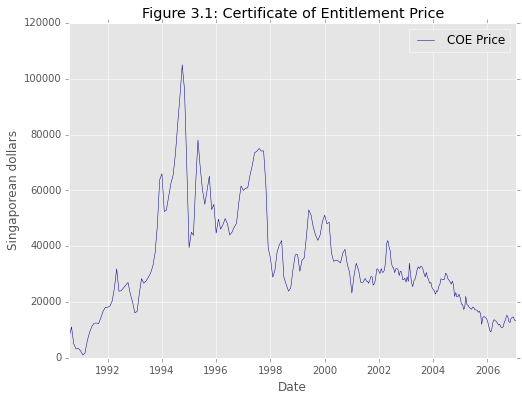

In [13]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8,6)

# Observed data
time = spreadsheet['DATE'].tolist()
price = data.tolist()

plt.plot(time, price, "-", label="COE Price", color="darkblue", linewidth='0.5')
plt.title("Figure 3.1: Certificate of Entitlement Price")
plt.xlabel("Date")
plt.ylabel("Singaporean dollars")
plt.legend()
plt.show()

# PART 2
_pg. 39-42_
## How to Scale the Input Attributes

In [14]:
from sklearn import preprocessing
x = data
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

In [15]:
print scaler

MinMaxScaler(copy=True, feature_range=(0, 1))


In [16]:
print type(x)

<class 'pandas.core.series.Series'>


In [17]:
x = np.array(x).reshape(-1,1)
# NUMPY
# Why did we use -1 here?

In [18]:
print type(x)

<type 'numpy.ndarray'>


## Log Transform

Here the author is transforming the data because as he says "it helps" with this specific set of data, __however__ this is __NOT__ a generally applicable statement.

In [19]:
x = np.log(x)
x[0:5]

array([[ 8.90923528],
       [ 9.31470039],
       [ 8.51759311],
       [ 8.06148687],
       [ 8.13446757]])

## Scale `x`

In [20]:
x = scaler.fit_transform(x)

In [21]:
x = x.reshape(-1)
print x.shape

(265,)


In [22]:
print np.min(x)

0.0


In [23]:
print np.max(x)

1.0


# PART 3
_pg. 42-49_

## Working with `statsmodels` Library

In [24]:
from statsmodels.tsa.stattools import pacf

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [25]:
x_pacf = pacf(x, nlags=5, method='ols')

In [26]:
print x_pacf

[ 1.          0.95969034 -0.27093837  0.22144024 -0.04729577  0.07360662]


## Import `nnet_ts`

This example from the book uses the `theano` backend for `keras`, but this is not important.

Use `pip install theano` from the command-line if you have not already installed theano.

In [27]:
from nnet_ts import *
count = 0
ahead = 12
pred = list()

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)


## The `while` Loop

We will use the same NN architecture as in Figure 2.5 on page 27.

In [28]:
while count < ahead:
    np.random.seed(2016)
    
    # Try to understand this line, where are we in the series?
    end = len(x) - ahead + count
    
    # Set the NN parameters
    fit1 = TimeSeriesNnet(hidden_layers=[7,3], activation_functions=["tanh", "tanh"])

    # What is the lag parameter doing?
    fit1.fit(x[0:end], lag=1, epochs=100)

    # What are we predicting?
    out = fit1.predict_ahead(n_ahead=1)
    
    print "Obs {:02d}: x={:0.4f}  prediction={:0.4f} ".format(count+1, round(x[count], 4), round(pd.Series(out), 4))
    pred.append(out)   
    count += 1

INFO:Building regressor matrix
INFO:Scaling data
INFO:Checking network consistency
INFO:Training neural net
INFO:Building regressor matrix
INFO:Scaling data
INFO:Checking network consistency
INFO:Training neural net


Obs 01: x=0.4303  prediction=0.5147 


INFO:Building regressor matrix
INFO:Scaling data
INFO:Checking network consistency
INFO:Training neural net


Obs 02: x=0.5174  prediction=0.5266 


INFO:Building regressor matrix
INFO:Scaling data
INFO:Checking network consistency
INFO:Training neural net


Obs 03: x=0.3462  prediction=0.5470 


INFO:Building regressor matrix
INFO:Scaling data
INFO:Checking network consistency
INFO:Training neural net


Obs 04: x=0.2482  prediction=0.5620 


INFO:Building regressor matrix
INFO:Scaling data
INFO:Checking network consistency
INFO:Training neural net


Obs 05: x=0.2639  prediction=0.5859 


INFO:Building regressor matrix
INFO:Scaling data
INFO:Checking network consistency
INFO:Training neural net


Obs 06: x=0.1979  prediction=0.5613 


INFO:Building regressor matrix
INFO:Scaling data
INFO:Checking network consistency
INFO:Training neural net


Obs 07: x=0.0000  prediction=0.5462 


INFO:Building regressor matrix
INFO:Scaling data
INFO:Checking network consistency
INFO:Training neural net


Obs 08: x=0.1064  prediction=0.5525 


INFO:Building regressor matrix
INFO:Scaling data
INFO:Checking network consistency
INFO:Training neural net


Obs 09: x=0.3875  prediction=0.5579 


INFO:Building regressor matrix
INFO:Scaling data
INFO:Checking network consistency
INFO:Training neural net


Obs 10: x=0.4726  prediction=0.5832 


INFO:Building regressor matrix
INFO:Scaling data
INFO:Checking network consistency
INFO:Training neural net


Obs 11: x=0.5188  prediction=0.5691 
Obs 12: x=0.5406  prediction=0.5575 


### QUESTION: Do the prediction values make sense?

## Realized and Predicted Values

Now we need to undo the scaling and log transformation we used to preprocess the data.

In [29]:
pred1 = scaler.inverse_transform(pred)
pred1 = np.exp(pred1)
print np.round(pred1, 1)

[[ 10964. ]
 [ 11585.5]
 [ 12741.5]
 [ 13661.9]
 [ 15267. ]
 [ 13617.9]
 [ 12694.4]
 [ 13073.2]
 [ 13401.3]
 [ 15080.6]
 [ 14124.5]
 [ 13377.2]]


## Visualizing the Results

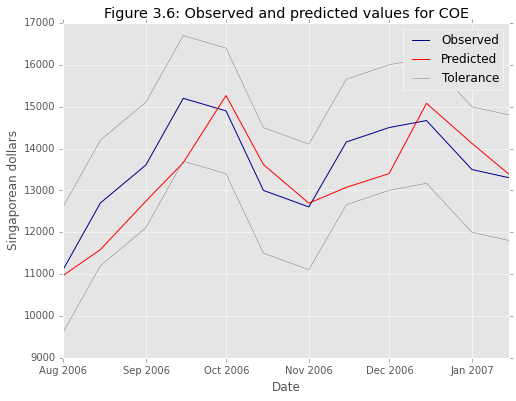

In [30]:
# FIGURE 3.6 (p. 49)
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)

# Original Series
plt.plot(time[-12:], price[-12:], linestyle='solid', label="Observed", color="darkblue", linewidth='1')

# Predictions
plt.plot(time[-12:], pred1, linestyle='solid', label="Predicted", color="red", linewidth='1')

# Desired Tolerance
max_price = [p + 1500 for p in price]
min_price = [p - 1500 for p in price]
# Why are we using -12 for the index?
# Answer:
plt.plot(time[-12:], max_price[-12:], linestyle='solid', label="Tolerance", color="grey", linewidth='0.5')
plt.plot(time[-12:], min_price[-12:], linestyle='solid', color="grey", linewidth='0.5')

# Figure Settings
plt.title("Figure 3.6: Observed and predicted values for COE")
plt.xlabel("Date")
plt.ylabel("Singaporean dollars")
plt.ylim(9000,17000)
plt.legend()
plt.show()